<a href="https://colab.research.google.com/github/cagBRT/PointCloud/blob/main/PointNetClass.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Clone the entire repo.
!git clone -s https://github.com/cagBRT/PointCloud.git cloned-repo
%cd cloned-repo

Cloning into 'cloned-repo'...
remote: Enumerating objects: 231, done.
remote: Counting objects: 100% (167/167), done.
remote: Compressing objects: 100% (86/86), done.
remote: Total 231 (delta 98), reused 131 (delta 78), pack-reused 64
Receiving objects: 100% (231/231), 44.02 MiB | 21.15 MiB/s, done.
Resolving deltas: 100% (117/117), done.
/content/cloned-repo


In [2]:
from IPython.display import Image

https://towardsdatascience.com/deep-learning-on-point-clouds-implementing-pointnet-in-google-colab-1fd65cd3a263

# PointNet

This is an implementation of [PointNet: Deep Learning on Point Sets for 3D Classification and Segmentation](https://arxiv.org/abs/1612.00593) using PyTorch.


In this notebook we the PointNet model to classify point clouds



In [ ]:
Image("pointnetClassification.gif")

## Import libraries

In [3]:
import numpy as np
import math
import random
import os
import torch
import scipy.spatial.distance
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

import plotly.graph_objects as go
import plotly.express as px

path.py is a module wrapper for os.path



In [4]:
!pip install path.py;
from path import Path

In [5]:
random.seed = 42

# Get the dataset

In [ ]:
Image("3DModels.png")

The main problem is inefficient representation: cubic voxel grid of size 100 will have 1,000,000 voxels.

**Let's try using point clouds**

There are three main constraints:

- Point clouds are unordered. Algorithm has to be invariant to permutations of the input set.
- If we rotate a chair, it’s still a chair, right? Network must be invariant to rigid transformations.
- Network should capture interactions among points.

Download the [dataset](http://3dvision.princeton.edu/projects/2014/3DShapeNets/) directly to the Google Colab Runtime. It comprises 10 categories, 3,991 models for training and 908 for testing.

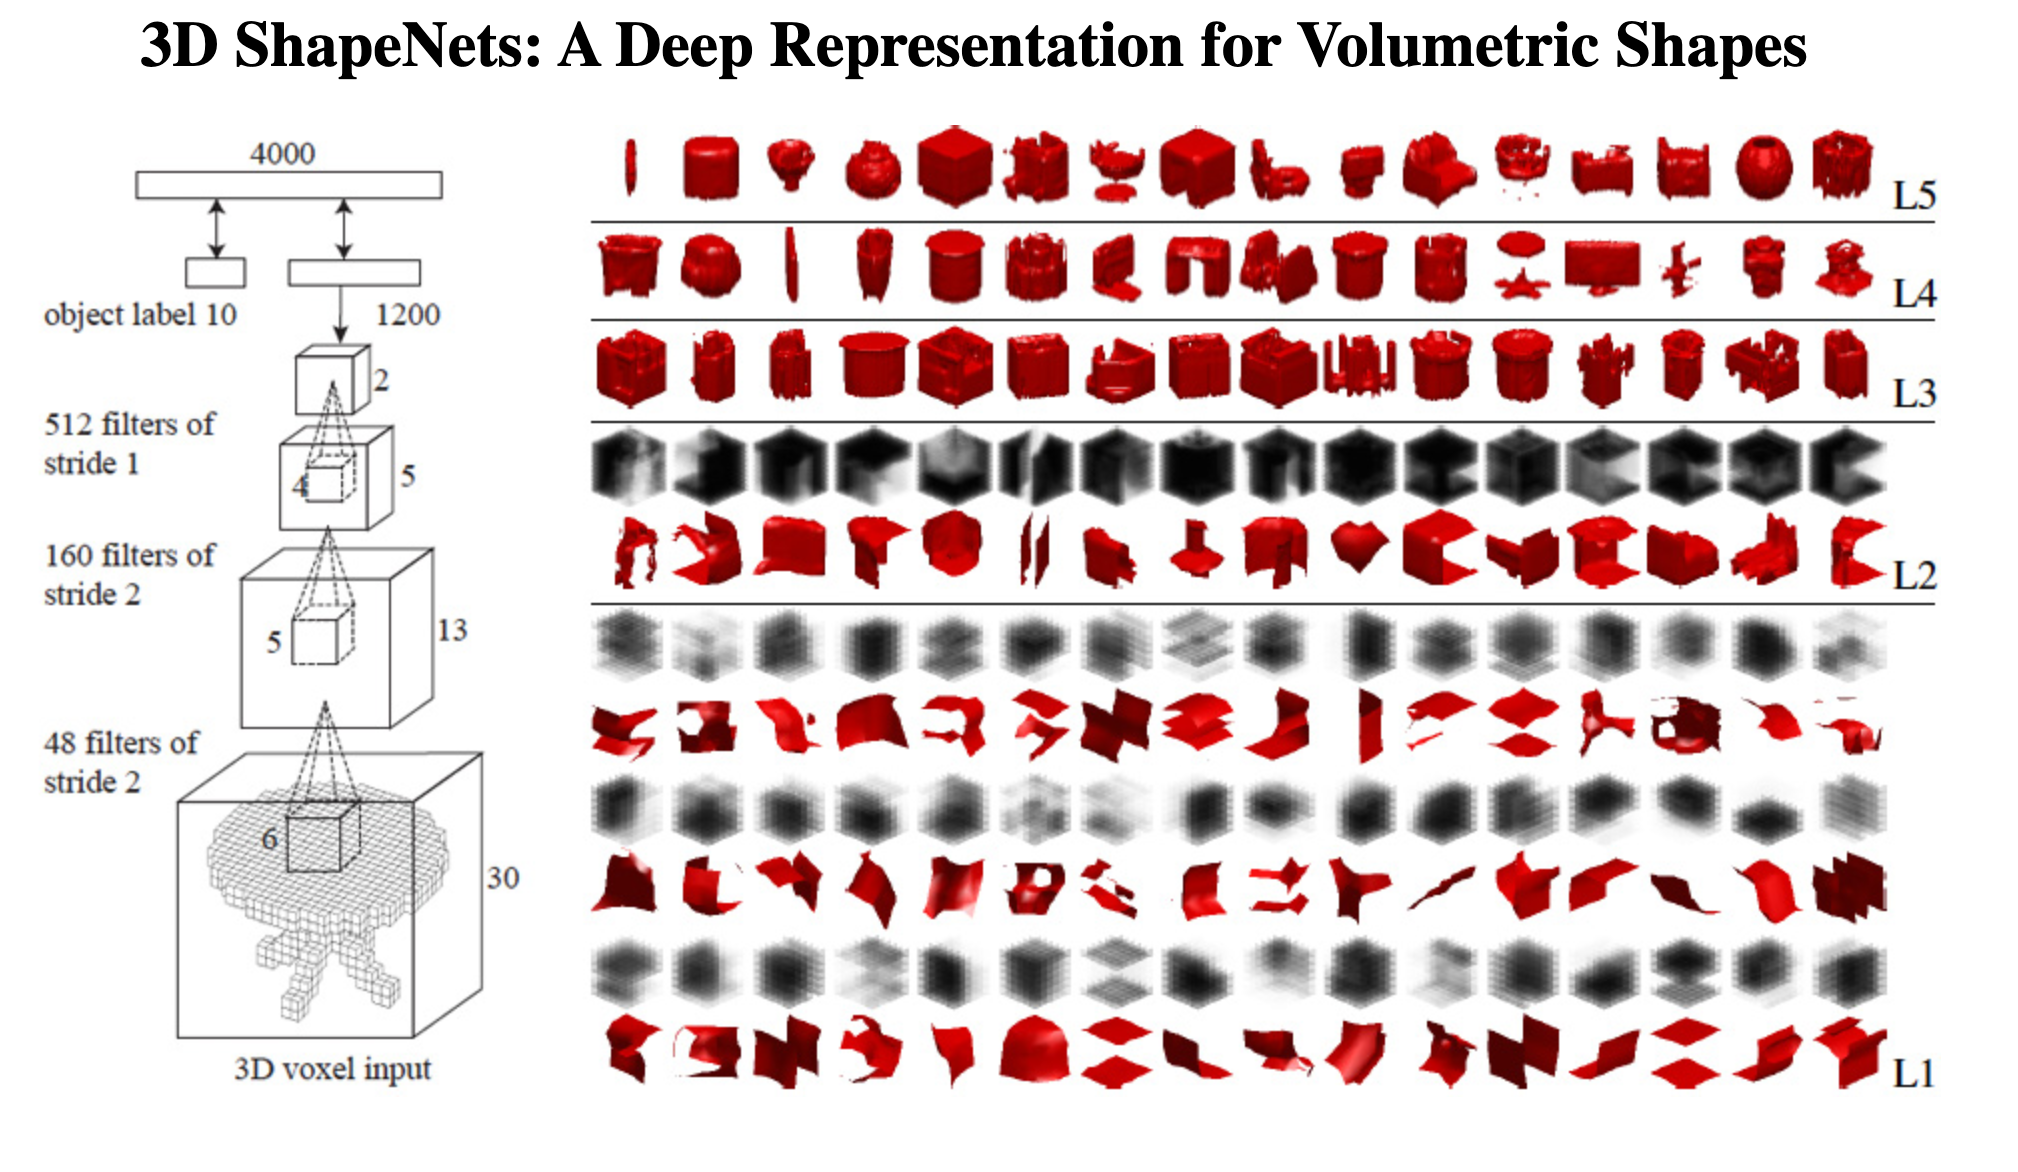

In [6]:
Image("datasetImage.png")

In [7]:
!wget http://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip

--2023-11-16 22:12:45--  http://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip
Resolving 3dvision.princeton.edu (3dvision.princeton.edu)... 128.112.136.67
Connecting to 3dvision.princeton.edu (3dvision.princeton.edu)|128.112.136.67|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip [following]
--2023-11-16 22:12:46--  https://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip
Connecting to 3dvision.princeton.edu (3dvision.princeton.edu)|128.112.136.67|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 473402300 (451M) [application/zip]
Saving to: ‘ModelNet10.zip’

ModelNet10.zip      100%[===================>] 451.47M  36.2MB/s    in 13s     

2023-11-16 22:12:58 (36.0 MB/s) - ‘ModelNet10.zip’ saved [473402300/473402300]



In [8]:
!unzip -q ModelNet10.zip;

In [9]:
path = Path("ModelNet10")

In [10]:
folders = [dir for dir in sorted(os.listdir(path)) if os.path.isdir(path/dir)]
classes = {folder: i for i, folder in enumerate(folders)};
classes

{'bathtub': 0,
 'bed': 1,
 'chair': 2,
 'desk': 3,
 'dresser': 4,
 'monitor': 5,
 'night_stand': 6,
 'sofa': 7,
 'table': 8,
 'toilet': 9}

This dataset consists of **.off** files that contain meshes represented by *vertices* and *triangular faces*.

We will need a function to read these types of files:

3D data is crucial for self-driving cars, autonomous robots, virtual and augmented reality. Different from 2D images that are represented as pixel arrays, it can be represented as polygonal mesh, volumetric pixel grid, point cloud, etc.

In [11]:
# @title read_off function
def read_off(file):
    if 'OFF' != file.readline().strip():
        raise('Not a valid OFF header')
    n_verts, n_faces, __ = tuple([int(s) for s in file.readline().strip().split(' ')])
    verts = [[float(s) for s in file.readline().strip().split(' ')] for i_vert in range(n_verts)]
    faces = [[int(s) for s in file.readline().strip().split(' ')][1:] for i_face in range(n_faces)]
    return verts, faces

In [12]:
with open(path/"bed/train/bed_0001.off", 'r') as f:
  verts, faces = read_off(f)

In [13]:
i,j,k = np.array(faces).T
x,y,z = np.array(verts).T

In [14]:
len(x)

2095

This function displays animated rotation of meshes and point clouds.

In [15]:
# @title vizualize_rotate function
def visualize_rotate(data):
    x_eye, y_eye, z_eye = 1.25, 1.25, 0.8
    frames=[]

    def rotate_z(x, y, z, theta):
        w = x+1j*y
        return np.real(np.exp(1j*theta)*w), np.imag(np.exp(1j*theta)*w), z

    for t in np.arange(0, 10.26, 0.1):
        xe, ye, ze = rotate_z(x_eye, y_eye, z_eye, -t)
        frames.append(dict(layout=dict(scene=dict(camera=dict(eye=dict(x=xe, y=ye, z=ze))))))
    fig = go.Figure(data=data,
                    layout=go.Layout(
                        updatemenus=[dict(type='buttons',
                                    showactive=False,
                                    y=1,
                                    x=0.8,
                                    xanchor='left',
                                    yanchor='bottom',
                                    pad=dict(t=45, r=10),
                                    buttons=[dict(label='Play',
                                                    method='animate',
                                                    args=[None, dict(frame=dict(duration=50, redraw=True),
                                                                    transition=dict(duration=0),
                                                                    fromcurrent=True,
                                                                    mode='immediate'
                                                                    )]
                                                    )
                                            ]
                                    )
                                ]
                    ),
                    frames=frames
            )

    return fig

In [16]:
visualize_rotate([go.Mesh3d(x=x, y=y, z=z, color='lightpink', opacity=0.50, i=i,j=j,k=k)]).show()

The mesh above definitely looks like a bed.


In [17]:
visualize_rotate([go.Scatter3d(x=x, y=y, z=z,
                                   mode='markers')]).show()

For the vertices, it's difficult for PointNet to classify point clouds like this one.

Let's write a function to accurately visualize point clouds so we could see vertices better.

In [18]:
# @title point cloud show function
def pcshow(xs,ys,zs):
    data=[go.Scatter3d(x=xs, y=ys, z=zs,
                                   mode='markers')]
    fig = visualize_rotate(data)
    fig.update_traces(marker=dict(size=2,
                      line=dict(width=2,
                      color='DarkSlateGrey')),
                      selector=dict(mode='markers'))
    fig.show()


The point cloud of the vertices

In [19]:
pcshow(x,y,z)

## Transforms

As we want it to look more like a real bed, let's write a function to sample points on the surface uniformly.

 ### Sample points

In [20]:
# @title Point Sampler function
class PointSampler(object):
    def __init__(self, output_size):
        assert isinstance(output_size, int)
        self.output_size = output_size

    def triangle_area(self, pt1, pt2, pt3):
        side_a = np.linalg.norm(pt1 - pt2)
        side_b = np.linalg.norm(pt2 - pt3)
        side_c = np.linalg.norm(pt3 - pt1)
        s = 0.5 * ( side_a + side_b + side_c)
        return max(s * (s - side_a) * (s - side_b) * (s - side_c), 0)**0.5

    def sample_point(self, pt1, pt2, pt3):
        # barycentric coordinates on a triangle
        # https://mathworld.wolfram.com/BarycentricCoordinates.html
        s, t = sorted([random.random(), random.random()])
        f = lambda i: s * pt1[i] + (t-s)*pt2[i] + (1-t)*pt3[i]
        return (f(0), f(1), f(2))


    def __call__(self, mesh):
        verts, faces = mesh
        verts = np.array(verts)
        areas = np.zeros((len(faces)))

        for i in range(len(areas)):
            areas[i] = (self.triangle_area(verts[faces[i][0]],
                                           verts[faces[i][1]],
                                           verts[faces[i][2]]))

        sampled_faces = (random.choices(faces,
                                      weights=areas,
                                      cum_weights=None,
                                      k=self.output_size))

        sampled_points = np.zeros((self.output_size, 3))

        for i in range(len(sampled_faces)):
            sampled_points[i] = (self.sample_point(verts[sampled_faces[i][0]],
                                                   verts[sampled_faces[i][1]],
                                                   verts[sampled_faces[i][2]]))

        return sampled_points


In [21]:
pointcloud = PointSampler(3000)((verts, faces))

In [22]:
pcshow(*pointcloud.T)

This pointcloud looks much more like a bed!

### Normalize

Unit sphere

In [23]:
# @title Normalize the point cloud dataset function
class Normalize(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape)==2

        norm_pointcloud = pointcloud - np.mean(pointcloud, axis=0)
        norm_pointcloud /= np.max(np.linalg.norm(norm_pointcloud, axis=1))

        return  norm_pointcloud

In [24]:
norm_pointcloud = Normalize()(pointcloud)

Notice that axis limits have changed.

In [25]:
pcshow(*norm_pointcloud.T)

### Augmentations

Let's add *random rotation* of the whole pointcloud and random noise to its points.

In [26]:
# @title Random Roation function
class RandRotation_z(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape)==2

        theta = random.random() * 2. * math.pi
        rot_matrix = np.array([[ math.cos(theta), -math.sin(theta),    0],
                               [ math.sin(theta),  math.cos(theta),    0],
                               [0,                             0,      1]])

        rot_pointcloud = rot_matrix.dot(pointcloud.T).T
        return  rot_pointcloud

class RandomNoise(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape)==2

        noise = np.random.normal(0, 0.02, (pointcloud.shape))

        noisy_pointcloud = pointcloud + noise
        return  noisy_pointcloud

In [27]:
rot_pointcloud = RandRotation_z()(norm_pointcloud)
noisy_rot_pointcloud = RandomNoise()(rot_pointcloud)

In [28]:
pcshow(*noisy_rot_pointcloud.T)



---



---



---



### ToTensor

In [29]:

class ToTensor(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape)==2

        return torch.from_numpy(pointcloud)

In [30]:
ToTensor()(noisy_rot_pointcloud)

tensor([[ 0.4260,  0.1647,  0.1816],
        [ 0.4424, -0.7180, -0.0792],
        [ 0.4922,  0.4069, -0.0679],
        ...,
        [-0.3153,  0.4022,  0.1144],
        [-0.1389,  0.2251,  0.1537],
        [-0.0085,  0.2155,  0.0691]], dtype=torch.float64)

In [31]:
def default_transforms():
    return transforms.Compose([
                                PointSampler(1024),
                                Normalize(),
                                ToTensor()
                              ])

## Dataset

Now we can create a [custom PyTorch Dataset](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html)

In [32]:
class PointCloudData(Dataset):
    def __init__(self, root_dir, valid=False, folder="train", transform=default_transforms()):
        self.root_dir = root_dir
        folders = [dir for dir in sorted(os.listdir(root_dir)) if os.path.isdir(root_dir/dir)]
        self.classes = {folder: i for i, folder in enumerate(folders)}
        self.transforms = transform if not valid else default_transforms()
        self.valid = valid
        self.files = []
        for category in self.classes.keys():
            new_dir = root_dir/Path(category)/folder
            for file in os.listdir(new_dir):
                if file.endswith('.off'):
                    sample = {}
                    sample['pcd_path'] = new_dir/file
                    sample['category'] = category
                    self.files.append(sample)

    def __len__(self):
        return len(self.files)

    def __preproc__(self, file):
        verts, faces = read_off(file)
        if self.transforms:
            pointcloud = self.transforms((verts, faces))
        return pointcloud

    def __getitem__(self, idx):
        pcd_path = self.files[idx]['pcd_path']
        category = self.files[idx]['category']
        with open(pcd_path, 'r') as f:
            pointcloud = self.__preproc__(f)
        return {'pointcloud': pointcloud,
                'category': self.classes[category]}

Transforms for training. 1024 points per cloud as in the paper!

In [33]:
train_transforms = transforms.Compose([
                    PointSampler(1024),
                    Normalize(),
                    RandRotation_z(),
                    RandomNoise(),
                    ToTensor()
                    ])

In [34]:
train_ds = PointCloudData(path, transform=train_transforms)
valid_ds = PointCloudData(path, valid=True, folder='test', transform=train_transforms)

In [35]:
inv_classes = {i: cat for cat, i in train_ds.classes.items()};
inv_classes

{0: 'bathtub',
 1: 'bed',
 2: 'chair',
 3: 'desk',
 4: 'dresser',
 5: 'monitor',
 6: 'night_stand',
 7: 'sofa',
 8: 'table',
 9: 'toilet'}

In [36]:
print('Train dataset size: ', len(train_ds))
print('Valid dataset size: ', len(valid_ds))
print('Number of classes: ', len(train_ds.classes))
print('Sample pointcloud shape: ', train_ds[0]['pointcloud'].size())
print('Class: ', inv_classes[train_ds[0]['category']])

Train dataset size:  3991
Valid dataset size:  908
Number of classes:  10
Sample pointcloud shape:  torch.Size([1024, 3])
Class:  bathtub


In [37]:
train_loader = DataLoader(dataset=train_ds, batch_size=32, shuffle=True)
valid_loader = DataLoader(dataset=valid_ds, batch_size=64)

## PyTorch Model

In [ ]:
Image("PointNetSolves.png")

In [38]:
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F

class Tnet(nn.Module):
   def __init__(self, k=3):
      super().__init__()
      self.k=k
      self.conv1 = nn.Conv1d(k,64,1)
      self.conv2 = nn.Conv1d(64,128,1)
      self.conv3 = nn.Conv1d(128,1024,1)
      self.fc1 = nn.Linear(1024,512)
      self.fc2 = nn.Linear(512,256)
      self.fc3 = nn.Linear(256,k*k)

      self.bn1 = nn.BatchNorm1d(64)
      self.bn2 = nn.BatchNorm1d(128)
      self.bn3 = nn.BatchNorm1d(1024)
      self.bn4 = nn.BatchNorm1d(512)
      self.bn5 = nn.BatchNorm1d(256)


   def forward(self, input):
      # input.shape == (bs,n,3)
      bs = input.size(0)
      xb = F.relu(self.bn1(self.conv1(input)))
      xb = F.relu(self.bn2(self.conv2(xb)))
      xb = F.relu(self.bn3(self.conv3(xb)))
      pool = nn.MaxPool1d(xb.size(-1))(xb)
      flat = nn.Flatten(1)(pool)
      xb = F.relu(self.bn4(self.fc1(flat)))
      xb = F.relu(self.bn5(self.fc2(xb)))

      #initialize as identity
      init = torch.eye(self.k, requires_grad=True).repeat(bs,1,1)
      if xb.is_cuda:
        init=init.cuda()
      matrix = self.fc3(xb).view(-1,self.k,self.k) + init
      return matrix


class Transform(nn.Module):
   def __init__(self):
        super().__init__()
        self.input_transform = Tnet(k=3)
        self.feature_transform = Tnet(k=64)
        self.conv1 = nn.Conv1d(3,64,1)

        self.conv2 = nn.Conv1d(64,128,1)
        self.conv3 = nn.Conv1d(128,1024,1)


        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)

   def forward(self, input):
        matrix3x3 = self.input_transform(input)
        # batch matrix multiplication
        xb = torch.bmm(torch.transpose(input,1,2), matrix3x3).transpose(1,2)

        xb = F.relu(self.bn1(self.conv1(xb)))

        matrix64x64 = self.feature_transform(xb)
        xb = torch.bmm(torch.transpose(xb,1,2), matrix64x64).transpose(1,2)

        xb = F.relu(self.bn2(self.conv2(xb)))
        xb = self.bn3(self.conv3(xb))
        xb = nn.MaxPool1d(xb.size(-1))(xb)
        output = nn.Flatten(1)(xb)
        return output, matrix3x3, matrix64x64

class PointNet(nn.Module):
    def __init__(self, classes = 10):
        super().__init__()
        self.transform = Transform()
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, classes)


        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(256)
        self.dropout = nn.Dropout(p=0.3)
        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, input):
        xb, matrix3x3, matrix64x64 = self.transform(input)
        xb = F.relu(self.bn1(self.fc1(xb)))
        xb = F.relu(self.bn2(self.dropout(self.fc2(xb))))
        output = self.fc3(xb)
        return self.logsoftmax(output), matrix3x3, matrix64x64

In [39]:
def pointnetloss(outputs, labels, m3x3, m64x64, alpha = 0.0001):
    criterion = torch.nn.NLLLoss()
    bs=outputs.size(0)
    id3x3 = torch.eye(3, requires_grad=True).repeat(bs,1,1)
    id64x64 = torch.eye(64, requires_grad=True).repeat(bs,1,1)
    if outputs.is_cuda:
        id3x3=id3x3.cuda()
        id64x64=id64x64.cuda()
    diff3x3 = id3x3-torch.bmm(m3x3,m3x3.transpose(1,2))
    diff64x64 = id64x64-torch.bmm(m64x64,m64x64.transpose(1,2))
    return criterion(outputs, labels) + alpha * (torch.norm(diff3x3)+torch.norm(diff64x64)) / float(bs)

## Training loop

You can find a pretrained model [here](https://drive.google.com/open?id=1nDG0maaqoTkRkVsOLtUAR9X3kn__LMSL)

In [40]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [41]:
pointnet = PointNet()
pointnet.to(device);

In [42]:
optimizer = torch.optim.Adam(pointnet.parameters(), lr=0.001)

In [43]:
def train(model, train_loader, val_loader=None,  epochs=4, save=True):
    for epoch in range(epochs):
        pointnet.train()
        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data['pointcloud'].to(device).float(), data['category'].to(device)
            optimizer.zero_grad()
            outputs, m3x3, m64x64 = pointnet(inputs.transpose(1,2))

            loss = pointnetloss(outputs, labels, m3x3, m64x64)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 10 == 9:    # print every 10 mini-batches
                    print('[Epoch: %d, Batch: %4d / %4d], loss: %.3f' %
                        (epoch + 1, i + 1, len(train_loader), running_loss / 10))
                    running_loss = 0.0

        pointnet.eval()
        correct = total = 0

        # validation
        if val_loader:
            with torch.no_grad():
                for data in val_loader:
                    inputs, labels = data['pointcloud'].to(device).float(), data['category'].to(device)
                    outputs, __, __ = pointnet(inputs.transpose(1,2))
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
            val_acc = 100. * correct / total
            print('Valid accuracy: %d %%' % val_acc)

        # save the model
        if save:
            torch.save(pointnet.state_dict(), "save_"+str(epoch)+".pth")

In [44]:
train(pointnet, train_loader, valid_loader,  save=True)

[Epoch: 1, Batch:   10 /  125], loss: 2.003
[Epoch: 1, Batch:   20 /  125], loss: 1.669
[Epoch: 1, Batch:   30 /  125], loss: 1.508
[Epoch: 1, Batch:   40 /  125], loss: 1.582
[Epoch: 1, Batch:   50 /  125], loss: 1.364
[Epoch: 1, Batch:   60 /  125], loss: 1.255
[Epoch: 1, Batch:   70 /  125], loss: 1.147
[Epoch: 1, Batch:   80 /  125], loss: 1.040
[Epoch: 1, Batch:   90 /  125], loss: 1.125
[Epoch: 1, Batch:  100 /  125], loss: 1.034
[Epoch: 1, Batch:  110 /  125], loss: 1.050
[Epoch: 1, Batch:  120 /  125], loss: 0.906
Valid accuracy: 65 %
[Epoch: 2, Batch:   10 /  125], loss: 0.836
[Epoch: 2, Batch:   20 /  125], loss: 0.811
[Epoch: 2, Batch:   30 /  125], loss: 0.815
[Epoch: 2, Batch:   40 /  125], loss: 0.737
[Epoch: 2, Batch:   50 /  125], loss: 0.900
[Epoch: 2, Batch:   60 /  125], loss: 1.069
[Epoch: 2, Batch:   70 /  125], loss: 0.795
[Epoch: 2, Batch:   80 /  125], loss: 0.754
[Epoch: 2, Batch:   90 /  125], loss: 0.612
[Epoch: 2, Batch:  100 /  125], loss: 0.746
[Epoch: 2, 

Typically we look at loss and accuracy, but for this classification problem we will need a metric that accounts for incorrect classification as well as correct classification. Think of the typical confusion matrix: true positives, false negatives, true negatives, and false positives; we want a classifier that performs well on all of these. The Matthews Correlation Coefficient (MCC) quantifies how well our model performs on all of these metrics and is considered to be a more reliable single metric of performance than accuracy or F1 score [3]. The MCC ranges from -1 to 1, where -1 is the worst performance, 1 is the best performance, and 0 is a Random Guess. We can use the MCC with PyTorch via torchmetrics.



We can see that the accuracy goes up for both training and validation, but the MCC only goes up for training and not validation. This could be caused by classes with very small sample sizes for some of the classes in the validation and test splits; so in this case the MCC may not be the best single metric for validation and test. This warrants some more investigation as to when the MCC is a good metric; i.e. how much imbalance is too much for the MCC? How many samples does each class need for the MCC to be effective?

In [1]:
Image("Metrics.png")

NameError: ignored

## Test

In [2]:
torch.save(pointnet.state_dict(), "save_"+str(epoch)+".pth")

NameError: ignored

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
pointnet = PointNet()
pointnet.load_state_dict(torch.load('save.pth'))
pointnet.eval();

In [ ]:
all_preds = []
all_labels = []
with torch.no_grad():
    for i, data in enumerate(valid_loader):
        print('Batch [%4d / %4d]' % (i+1, len(valid_loader)))

        inputs, labels = data['pointcloud'].float(), data['category']
        outputs, __, __ = pointnet(inputs.transpose(1,2))
        _, preds = torch.max(outputs.data, 1)
        all_preds += list(preds.numpy())
        all_labels += list(labels.numpy())



In [ ]:
cm = confusion_matrix(all_labels, all_preds);
cm

In [ ]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

# function from https://deeplizard.com/learn/video/0LhiS6yu2qQ
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
plt.figure(figsize=(8,8))
plot_confusion_matrix(cm, list(classes.keys()), normalize=True)

In [ ]:
plt.figure(figsize=(8,8))
plot_confusion_matrix(cm, list(classes.keys()), normalize=False)